# Pre-processing

In [1]:
import warnings
warnings.filterwarnings("ignore")
# package
import numpy as np
import pandas as pd
import talib as ta
import matplotlib.pyplot as plt

# Machine learning package
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso, LassoLarsCV
from sklearn.linear_model import Ridge,RidgeCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import r2_score

# Data fetching package
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

In [2]:
# Underlying = '^NSEI'
underlying = '000001.SS'
st = '2009-01-01'
et = '2019-01-01'
print("The dataset is stock price from " + underlying + " (China)" )

The dataset is stock price from 000001.SS (China)


In [3]:
# Data pre-processing
df = pdr.get_data_yahoo(underlying, st, et)
df = df.dropna()
df.head()
df = df.iloc[:,:4]
df.head()
# Factor choose
df['S_10'] = df['Close'].rolling(window=10).mean()
df['Corr'] = df['Close'].rolling(window=10).corr(df['S_10'])
df['RSI'] = ta.RSI(np.array(df['Close']), timeperiod =10)
df['Open-Close'] = df['Open'] - df['Close'].shift(1)
df['Open-Open'] = df['Open'] - df['Open'].shift(1)
df = df.dropna()
X = df.iloc[:,:9]
print('The factors chosen are:\n',df.columns)

[*********************100%***********************]  1 of 1 completed
The factors chosen are:
 Index(['Open', 'High', 'Low', 'Close', 'S_10', 'Corr', 'RSI', 'Open-Close',
       'Open-Open'],
      dtype='object')


In [4]:
# Pattern pre-processing
y = np.where(df['Close'].shift(-1) > df['Close'],1,-1) 

# Pattern imbalance
unique, counts = np.unique(y, return_counts=True)
print("The dataset balance ratio is %f" %(max(counts)/min(counts)))
if max(counts)/min(counts) > 4:
    print("The dataset has class imbalance issue")
else:
    print("The dataset has no class imbalance issue")

The dataset balance ratio is 1.136283
The dataset has no class imbalance issue


In [5]:
# Dataset split(0.7/0.3)
split = int(0.7*len(df))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

In [6]:
# Get classification report    
def get_report(report,aoc):    
    index = {'-1','1','macro avg','weighted avg'}
    index2 = {'accuracy'}
    test_1 = {key:value for key,value in report.items() if key in index}
    report2 = pd.DataFrame(test_1)
    report3 = pd.DataFrame([report['accuracy'],aoc], index=['accuracy','AUC'])
    print(report2)
    print(report3)
    r = [report['accuracy'],report2.iat[0,3],report2.iat[1,3],report2.iat[2,3],aoc]
    return r

# 1.Logistic Regression

In [7]:
# 1.Logistic Regression
model = LogisticRegression()

model = model.fit(X_train,y_train)


pd.DataFrame(list(zip(X.columns, np.transpose(model.coef_))))

probability = model.predict_proba(X_test)


Confusion Matrix:
 [[165 176]
 [187 197]]
Model Score = 0.4993103448275862


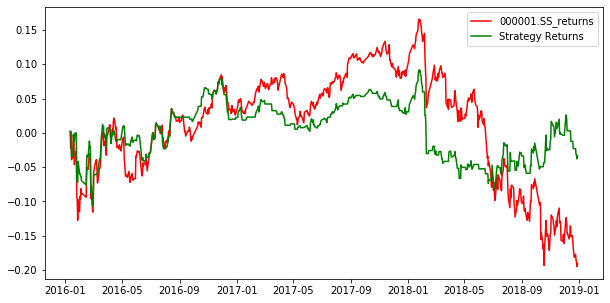

                   -1           1   macro avg  weighted avg
precision    0.468750    0.528150    0.498450      0.500212
recall       0.483871    0.513021    0.498446      0.499310
f1-score     0.476190    0.520476    0.498333      0.499646
support    341.000000  384.000000  725.000000    725.000000
                 0
accuracy  0.499310
AUC       0.498446


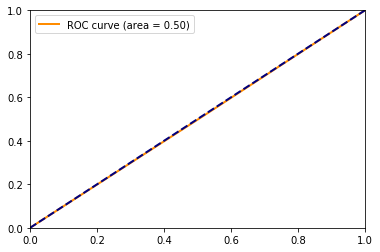

In [8]:
predicted = model.predict(X_test)
print('Confusion Matrix:\n',metrics.confusion_matrix(y_test, predicted))
report1 = metrics.classification_report(y_test, predicted, output_dict=True)
print('Model Score =',model.score(X_test,y_test))
cross_val = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)


underlying_col = underlying + '_returns'
df['Predicted_Signal'] = np.where(model.predict(X) <=0,0,1)
df[underlying_col] = np.log(df['Close']/df['Close'].shift(1))
Cumulative_underlying_returns = np.cumsum(df[split:][underlying_col])
# assume the close price we are using is the 'pseudo close price', i.e. the price 5 mins before close
# then we can get the position during the last 5mins
df['Startegy_returns'] = df[underlying_col] * df['Predicted_Signal'].shift(1)
Cumulative_Strategy_returns = np.cumsum(df[split:]['Startegy_returns'])
plt.figure(figsize=(10,5))
plt.plot(Cumulative_underlying_returns, color='r',label = underlying_col)
plt.plot(Cumulative_Strategy_returns, color='g', label = 'Strategy Returns')
plt.legend()
plt.show()


fpr, tpr, thresholds = roc_curve(y_test, predicted, pos_label=1)
roc_auc1 = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc1)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend()

report1 = get_report(report1,roc_auc1)


# 2.Linear Regression

Confusion Matrix:
 [[175 166]
 [195 189]]
Model Score = -0.008973920947332736


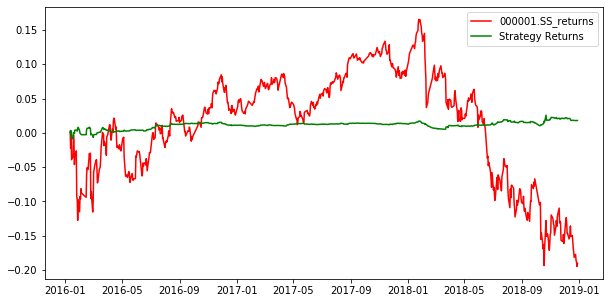

                   -1           1   macro avg  weighted avg
precision    0.472973    0.532394    0.502684      0.504446
recall       0.513196    0.492188    0.502692      0.502069
f1-score     0.492264    0.511502    0.501883      0.502454
support    341.000000  384.000000  725.000000    725.000000
                 0
accuracy  0.502069
AUC       0.502692


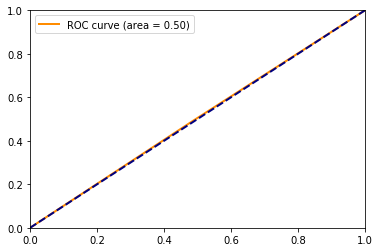

In [9]:
# 2.Linear Regression
model2 = LinearRegression()

model2 = model2.fit(X_train,y_train)
model2.coef_
pd.DataFrame(list(zip(X.columns, np.transpose(model2.coef_))))

predicted2 = model2.predict(X_test)
predicted2 = np.where(predicted2 > 0,1,-1)
print('Confusion Matrix:\n',metrics.confusion_matrix(y_test, predicted2))
report2 = metrics.classification_report(y_test, predicted2,output_dict=True)
print('Model Score =',model2.score(X_test,y_test))

underlying_col = underlying + '_returns'
df['Predicted_Signal'] = model2.predict(X)
df[underlying_col] = np.log(df['Close']/df['Close'].shift(1))
Cumulative_underlying_returns = np.cumsum(df[split:][underlying_col])
# assume the close price we are using is the 'pseudo close price', i.e. the price 5 mins before close
# then we can get the position during the last 5mins
df['Startegy_returns'] = df[underlying_col]* df['Predicted_Signal'].shift(1)
Cumulative_Strategy_returns = np.cumsum(df[split:]['Startegy_returns'])
plt.figure(figsize=(10,5))
plt.plot(Cumulative_underlying_returns, color='r',label = underlying_col)
plt.plot(Cumulative_Strategy_returns, color='g', label = 'Strategy Returns')
plt.legend()
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, predicted2, pos_label=1)
roc_auc2 = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc2)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend()

report2 = get_report(report2,roc_auc2)

# 3.LASSO

Best alpha: 0.00011526848613907012
Confusion Matrix:
 [[  9 332]
 [ 10 374]]
Model Score = -0.0013411736828308207
r^2 on test data:-0.893558


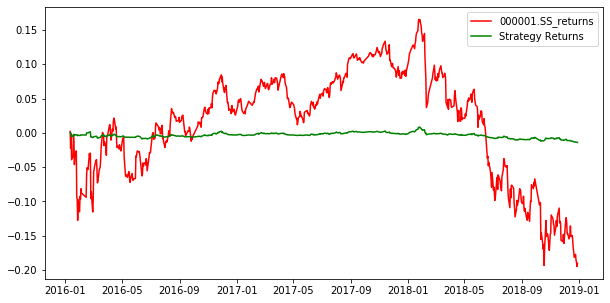

                   -1           1   macro avg  weighted avg
precision    0.473684    0.529745    0.501715      0.503377
recall       0.026393    0.973958    0.500176      0.528276
f1-score     0.050000    0.686239    0.368119      0.386987
support    341.000000  384.000000  725.000000    725.000000
                 0
accuracy  0.528276
AUC       0.500176


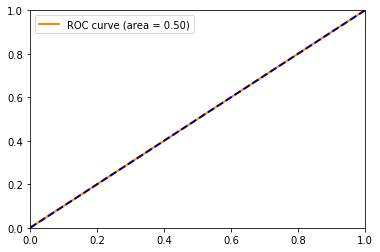

In [10]:
lasso = LassoLarsCV() 
lasso = lasso.fit(X_train,y_train)  
print('Best alpha:',lasso.alpha_)  
# 使用模型预测
predicted3 = lasso.predict(X_test)
predicted3 = np.where(predicted3 > 0,1,-1)
print('Confusion Matrix:\n',metrics.confusion_matrix(y_test, predicted3))
report3 = metrics.classification_report(y_test, predicted3,output_dict=True)
print('Model Score =',lasso.score(X_test,y_test))

pd.DataFrame(list(zip(X.columns, np.transpose(lasso.coef_))))

r2_score_lasso=r2_score(y_test,predicted3)
print('r^2 on test data:%f' %r2_score_lasso)
underlying_col = underlying + '_returns'
df['Predicted_Signal'] = lasso.predict(X)
df[underlying_col] = np.log(df['Close']/df['Close'].shift(1))
Cumulative_underlying_returns = np.cumsum(df[split:][underlying_col])
df['Startegy_returns'] = df[underlying_col]* df['Predicted_Signal'].shift(1)
Cumulative_Strategy_returns = np.cumsum(df[split:]['Startegy_returns'])
plt.figure(figsize=(10,5))
plt.plot(Cumulative_underlying_returns, color='r',label = underlying_col)
plt.plot(Cumulative_Strategy_returns, color='g', label = 'Strategy Returns')
plt.legend()
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, predicted3, pos_label=1)
roc_auc3 = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc3)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend()

report3 = get_report(report3,roc_auc3)

# 4.Ridge

Best alpha = 1.0
Confusion Matrix:
 [[176 165]
 [195 189]]
Model Score = -0.008971989823785664


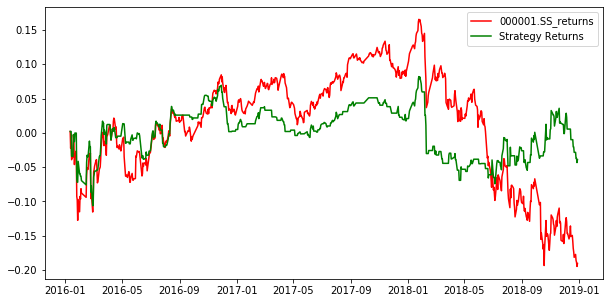

                   -1           1   macro avg  weighted avg
precision    0.474394    0.533898    0.504146      0.505911
recall       0.516129    0.492188    0.504158      0.503448
f1-score     0.494382    0.512195    0.503289      0.503817
support    341.000000  384.000000  725.000000    725.000000
                 0
accuracy  0.503448
AUC       0.504158


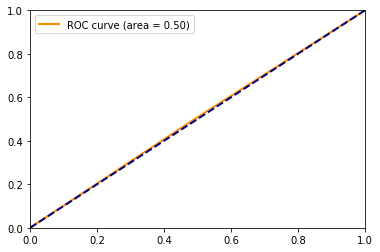

In [11]:
ridge = RidgeCV(alphas=[0.1, 0.1, 1.0])
ridge = ridge.fit(X_train, y_train)   
print('Best alpha =',ridge.alpha_)  

predicted4 = ridge.predict(X_test)
predicted4 = np.where(predicted4 > 0,1,-1)

print('Confusion Matrix:\n',metrics.confusion_matrix(y_test, predicted4))
report4 = metrics.classification_report(y_test, predicted4,output_dict=True)
print('Model Score =',ridge.score(X_test,y_test))


underlying_col = underlying + '_returns'
df['Predicted_Signal'] = np.where(ridge.predict(X) <=0,0,1)
df[underlying_col] = np.log(df['Close']/df['Close'].shift(1))
Cumulative_underlying_returns = np.cumsum(df[split:][underlying_col])

df['Startegy_returns'] = df[underlying_col] * df['Predicted_Signal'].shift(1)
Cumulative_Strategy_returns = np.cumsum(df[split:]['Startegy_returns'])
plt.figure(figsize=(10,5))
plt.plot(Cumulative_underlying_returns, color='r',label = underlying_col)
plt.plot(Cumulative_Strategy_returns, color='g', label = 'Strategy Returns')
plt.legend()
plt.show()


fpr, tpr, thresholds = roc_curve(y_test, predicted4, pos_label=1)
roc_auc4 = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc4)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend()

report4 = get_report(report4,roc_auc4)

# 5.SVC

Confusion Matrix:
 [[276  65]
 [299  85]]
Model Score = 0.4979310344827586


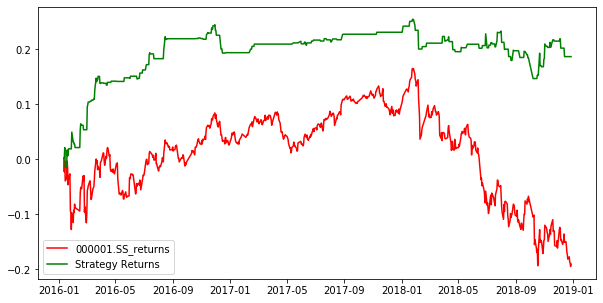

                   -1           1   macro avg  weighted avg
precision    0.480000    0.566667    0.523333      0.525903
recall       0.809384    0.221354    0.515369      0.497931
f1-score     0.602620    0.318352    0.460486      0.452056
support    341.000000  384.000000  725.000000    725.000000
                 0
accuracy  0.497931
AUC       0.515369


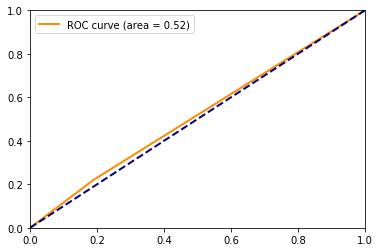

In [12]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

svc = SVC(kernel='linear', class_weight='balanced')
svc = svc.fit(X_train, y_train)

predicted5 = svc.predict(X_test)

predicted5 = np.where(predicted5 > 0,1,-1)
print('Confusion Matrix:\n',metrics.confusion_matrix(y_test, predicted5))
report5 = metrics.classification_report(y_test, predicted5,output_dict=True)
print('Model Score =',svc.score(X_test,y_test))

underlying_col = underlying + '_returns'
df['Predicted_Signal'] = np.where(svc.predict(X) <=0,0,1)
df[underlying_col] = np.log(df['Close']/df['Close'].shift(1))
Cumulative_underlying_returns = np.cumsum(df[split:][underlying_col])
df['Startegy_returns'] = df[underlying_col] * df['Predicted_Signal'].shift(1)
Cumulative_Strategy_returns = np.cumsum(df[split:]['Startegy_returns'])
plt.figure(figsize=(10,5))
plt.plot(Cumulative_underlying_returns, color='r',label = underlying_col)
plt.plot(Cumulative_Strategy_returns, color='g', label = 'Strategy Returns')
plt.legend()
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, predicted5, pos_label=1)
roc_auc5 = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc5)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend()

report5 = get_report(report5,roc_auc5)

# 6.Comparison of models

In [13]:
# Param List
scoreList = np.array([model.score(X_test,y_test)
                     ,model2.score(X_test,y_test)
                     ,lasso.score(X_test,y_test)
                     ,ridge.score(X_test,y_test)
                     ,svc.score(X_test,y_test)])
acyList = np.array([report1,report2,report3,report4,report5])

scoreIndex = np.argmax(scoreList)
acyIndex = np.argmax(acyList)


In [14]:
# Format Output
if np.argmax(acyList) == 0:
    a,b,c,d,e = report1
    f = 'Logistic Reg. Model'
elif np.argmax(acyList) == 1:
    a,b,c,d,e = report2
    f = 'Linear Reg. Model'
elif np.argmax(acyList) == 2:
    a,b,c,d,e = report3
    f = 'Lasso Reg. Model'
elif np.argmax(acyList) == 3:
    a,b,c,d,e = report4
    f = 'Ridge Reg. Model'
else:
    a,b,c,d,e = report5
    f = 'SVC Model'

print("%s performs the best for my dataset" % (f))
print("Daily, "+ underlying +' from '+st+' to ' +et+ ")\nWith the accuracy:%.3f, precision:%.3f, recall:%.3f, f1:%.3f, auc:%.3f" % (a,b,c,d,e))


SVC Model performs the best for my dataset
Daily, 000001.SS from 2009-01-01 to 2019-01-01)
With the accuracy:0.498, precision:0.526, recall:0.498, f1:0.452, auc:0.515
